# Sentiment Analysis Using Yelp, Amazon, and IMDB Reviews


Using Google Colab Notebook with Tesla K80 GPU. Loading in data from Google Drive. Inspired by https://realpython.com/python-keras-text-classification/



# Introduction

Welcome! In this notebook I am going to do sentiment analysis using reviews from Yelp, Amazon, and IMDB. Inspired by a real python blog post, I wanted to compare various machine learning models, looking to see which one worked best: shallow methods like Logistic Regression or deeper methods like a CNN.

# Guiding Question:

Which model works best to classify reviews as positive or negative? Logistic Regression, Naive Bayes, Random Forests, KNN, SVM, or Neural Networks?

# Workflow

I'll start off by trying out some of the shallow methods. The workflow is as follows:

 - define problem
 - choose measure of success
 - evaluation protocol
 - prepare the data
 - modeling
 - hyperparameter optimization
 - summarize
 
The feature preprocessing for the shallow methods will be a bit different from the deeper methods, but overall the process will be the same: find the best model, then optimize it. At the end we will compare our best 2 models, choosing the one with the best performance on the testing data.



# Shallow models:

### Defining the problem

Were looking to classify text as either having a positive sentiment or a negative sentiment, making this a binary classification problem. 

### Choosing a measure of Sucess

We will be looking to optimize the accuracy of our model.

### Evaluation protocol

Were looking to test various models, finding the optimal hyperparameters of the model for each dataset. In order to do this we'll seperate our prepared data into training and testing sets. To get a baseline score of how well our model is performing, we will train the models on the training data, and evaluate their accuracy scores on the testing data. 

Once we find the top model, we will try to optimize it using GridSearchCV. We will use K-Fold Cross Validation to see how well our model generalizes. 

### Preparing the data

Since I am using a Google Colab Notebook, Ill have to load in the datasets from my Google Drive. If you want to replicate this notebook, import drive from google.colab. You'll be provided with a url that'll take you to the authorization code. Copy and paste code. The datasets were downloaded from the UCI Machine Learning Repository and unzipped into drive: 
- https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences






In [1]:
# only necessary if you are using Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks"

 9c9cc17e8c7ef7ef46617853377f45f5-42df26fdf7740fdb678c8c622330c8c7c8f24570.zip
 amazon_cells_labelled.txt
'Copy of 6 Convolutional Neural Networks.ipynb'
 image_recognition_system.ipynb
 imdb_labelled.txt
 mnist_cnn.py
 sentiment_analysis.ipynb
 Titanic.csv
 Untitled0.ipynb
 Untitled1.ipynb
 yelp_labelled.txt


I will create one dataframe for all of the reviews. 

In [3]:
import pandas as pd

filepath_dict = {'yelp':   '/content/drive/My Drive/Colab Notebooks/yelp_labelled.txt',
                 'amazon': '/content/drive/My Drive/Colab Notebooks/amazon_cells_labelled.txt',
                 'imdb':   '/content/drive/My Drive/Colab Notebooks/imdb_labelled.txt'}
dataframes = []
for source, path in filepath_dict.items():
  # load into df
  df = pd.read_csv(path, names=['sentence','label'], sep='\t')
  # create name column
  df['source'] = source
  # add to dataframes
  dataframes.append(df)
  
# combine into 1 df by stacking
df = pd.concat(dataframes)
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 747
Data columns (total 3 columns):
sentence    2748 non-null object
label       2748 non-null int64
source      2748 non-null object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB
None


This isnt a huge dataset - less than 3,000 reviews. Lets take a look at one of the sources: Yelp

In [4]:
df_yelp = df[df["source"] == "yelp"]
df_yelp.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [5]:
df_yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
sentence    1000 non-null object
label       1000 non-null int64
source      1000 non-null object
dtypes: int64(1), object(2)
memory usage: 31.2+ KB


Since we want to find a general model capable of predicting whether or not a review is positive or negative, we could combine all of the datasets together and try to model them as one; or we could model each of the datasets individually.

Because we dont have a lot of data, I will combine them into one dataframe. I'll shuffle the index.

In [6]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()


,sentence,label,source
85,I love the Pho and the spring rolls oh so yumm...,1,yelp
328,His losing his marbles so early in the proceed...,0,imdb
166,This place is hands-down one of the best place...,1,yelp
794,My brother in law who works at the mall ate he...,0,yelp
597,It was clear that she had the range and abilit...,1,imdb


Load in some libraries we may, or may not use

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, RMSprop
from sklearn.linear_model import LogisticRegression
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Preparing the data

In [8]:
X = df["sentence"].values
y = df["label"].values
X.shape, y.shape

((2748,), (2748,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1923,), (825,))

In [10]:
y_train.shape, y_test.shape

((1923,), (825,))

In [11]:
# vectorize
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



print(X_train_vec.shape, X_test_vec.shape)

(1923, 4155) (825, 4155)


### Modeling

In [12]:
# models list
models = [("LR", LogisticRegression(random_state=0)),
          ("NB", MultinomialNB()),
          ("RF", RandomForestClassifier(random_state=0)), 
          ("KNN", KNeighborsClassifier()),
         ("SVC", SVC(random_state=0))]

# dictionary to store scores and model names
results = {}

# iterate through models list
for name, mod in models:
  model = mod
  model.fit(X_train_vec, y_train)
  score = model.score(X_test_vec, y_test)
  results[name] = score
  
results

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'KNN': 0.776969696969697,
 'LR': 0.8303030303030303,
 'NB': 0.8254545454545454,
 'RF': 0.7503030303030302,
 'SVC': 0.503030303030303}

- Logistic Regression 83.03% accuracy
- Naive Bayes 82.54% accuracy

Lets try to find the optimal model for both the Naive Bayes and the Logistic Regression.

### Hyperparameter optimization

In [13]:
# parameter dictionary for naive bayes
params = {"alpha": [0.001,0.01,0.1,1,10,100]}

# instantiate model
nb = MultinomialNB()

# gridsearch with K-Fold cv
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

nb_grid = GridSearchCV(nb,
                      param_grid=params,
                      scoring='accuracy',
                      cv=kfold)
nb_grid.fit(X_train_vec, y_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [14]:
print(f"Best params: {nb_grid.best_params_}")
print(f"Best score: {nb_grid.best_score_}")

Best params: {'alpha': 0.1}
Best score: 0.7919916796671866


In [15]:
best_nb = nb_grid.best_estimator_
best_nb

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [45]:
# parameter dictionary for naive bayes
params = {"C": [0.001,0.01,0.1,1,10,100],
         "penalty": ["l1", "l2"]}

# instantiate model
lr = LogisticRegression(random_state=0)

# gridsearch with K-Fold cv
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

lr_grid = GridSearchCV(lr,
                      param_grid=params,
                      scoring='accuracy',
                      cv=kfold)
lr_grid.fit(X_train_vec, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [46]:
print(f"Best params: {lr_grid.best_params_}")
print(f"Best score: {lr_grid.best_score_}")

Best params: {'C': 10, 'penalty': 'l2'}
Best score: 0.8070722828913156


In [47]:
best_lr = lr_grid.best_estimator_
best_lr

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Using grid search we found the best hyperparameters of the Naive Bayes to be Alpha = 0.1. The best model got an accuracy of 79.2% - not much different from before optimization. 

Our best Logistic Regression model used L2 regularization and had a C = 10. Its best score was 80.7%.

Now lets try out some deep methods to see how they perform.


# Deep Models:

### Defining the problem

Binary classification

### Choosing a measure of sucess

Loss function: categorical_crossentropy
optimzers: adam, rmsprop
metrics: accuracy

### Evaluation protocol

- Train 70%, test 30% for training
- K-Fold with 3 splits during hyperparameter optimization

### Preparing the data

For deeper models we will want to use a dense matrix instead of a sparse matrix. To do this we will first tokenize the text into sequences, which will be padded with zeros. 


In [16]:
# from earlier
X.shape, y.shape

((2748,), (2748,))

In [17]:
X

array(['I love the Pho and the spring rolls oh so yummy you have to try.',
       'His losing his marbles so early in the proceedings is totally implausible and unconvincing.  ',
       'This place is hands-down one of the best places to eat in the Phoenix metro area.',
       ...,
       "The building itself seems pretty neat; the bathroom is pretty trippy, but I wouldn't eat here again.",
       'I had strawberry tea, which was good.',
       'T-Mobile has the best customer service anywhere.'], dtype=object)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1923,), (825,))

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)


We set the num_words to 5,000. Now we have a vocab of 4,308 words.

Lets now pad them using the pad_sequences() function. We'll set the maxlen of the sequences to 100.

In [20]:
maxlen = 100
vocab_size = len(tokenizer.word_index) + 1


# X_train/test_nn stands for neural networks
# this will help me distinguish between the sparse and dense vectors

X_train_nn = pad_sequences(X_train_tk, maxlen=maxlen)
X_test_nn = pad_sequences(X_test_tk, maxlen=maxlen)

X_train_nn.shape, X_test_nn.shape


((1923, 100), (825, 100))

Our data now has 100 dimensions. Before we input into the model we need to establish some parameters for the embedding layer:


- input_dim = vocab_size (4308)
- output_dim = embedding_dim (50) or batch_size
- input_length= maxlen (100)

### Modeling

This part will be a little different from the earlier models. Instead of using a set of different models and finding the best one, well try a few different architectures from scratch. Once we find a solid network architecture that gives us decent accuracy, we can then try to optimize it.


Lets start with a convolutional neural network. Ill try out a smaller convolutional network first, then one with more layers.

In [21]:
# build model_a: CNN
embedding_dim = 50
K.clear_session()

model_a = Sequential()
model_a.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_a.add(layers.Conv1D(32, 5, activation='relu'))
model_a.add(layers.GlobalMaxPooling1D())
model_a.add(layers.Dense(10, activation='relu'))
model_a.add(layers.Dense(1, activation='sigmoid'))

# compile
model_a.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           212200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            8032      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 220,573
Trainable params: 220,573
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train model and store history to visualize
history_a = model_a.fit(X_train_nn, y_train,
                   epochs=10,
                   batch_size=10,
                   validation_split=0.1)

Train on 1730 samples, validate on 193 samples
Epoch 1/10
1730/1730 [==============================] - 6s 3ms/step - loss: 0.6762 - acc: 0.5954 - val_loss: 0.6383 - val_acc: 0.6839
Epoch 2/10
1730/1730 [==============================] - 1s 735us/step - loss: 0.5080 - acc: 0.8168 - val_loss: 0.4915 - val_acc: 0.7927
Epoch 3/10
1730/1730 [==============================] - 1s 744us/step - loss: 0.3244 - acc: 0.8931 - val_loss: 0.4567 - val_acc: 0.8031
Epoch 4/10
1730/1730 [==============================] - 1s 717us/step - loss: 0.2105 - acc: 0.9295 - val_loss: 0.4454 - val_acc: 0.8187
Epoch 5/10
1730/1730 [==============================] - 1s 717us/step - loss: 0.1449 - acc: 0.9526 - val_loss: 0.4676 - val_acc: 0.8342
Epoch 6/10
1730/1730 [==============================] - 1s 703us/step - loss: 0.0990 - acc: 0.9705 - val_loss: 0.4717 - val_acc: 0.8238
Epoch 7/10
1730/1730 [==============================] - 1s 718us/step - loss: 0.0710 - acc: 0.9803 - val_loss: 0.5105 - val_acc: 0.8342
Epo

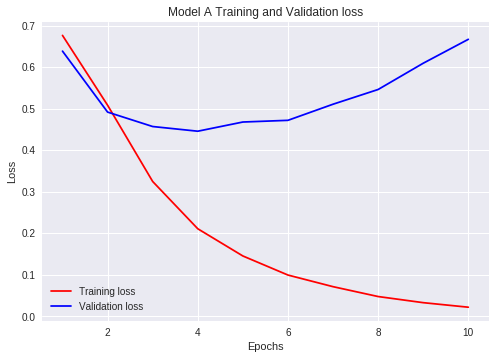

In [23]:
history_dict_a = history_a.history
loss = history_dict_a['loss']
val_loss = history_dict_a['val_loss']
acc = history_dict_a['acc']
val_acc = history_dict_a['val_acc']

epochs = range(1,11)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Model A Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

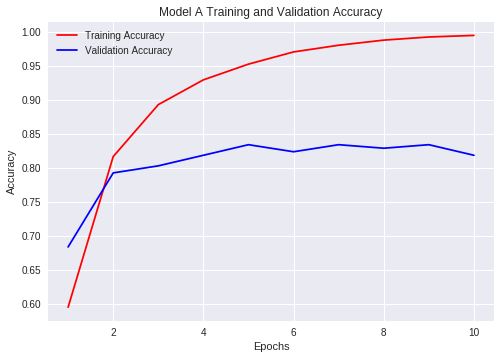

In [24]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Model A Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Lets now try a deeper model.

In [25]:
K.clear_session()
model_a2 = Sequential()
model_a2.add(layers.Embedding(vocab_size, 32))
model_a2.add(layers.Conv1D(32, 5, activation='relu'))
model_a2.add(layers.MaxPooling1D())
model_a2.add(layers.Conv1D(32, 5, activation='relu'))
model_a2.add(layers.GlobalMaxPooling1D())
model_a2.add(layers.Dense(10, activation='relu'))
model_a2.add(layers.Dropout(0.25))
model_a2.add(layers.Dense(1, activation='sigmoid'))

# early stopping to help with overfitting
early_stop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

# compile
model_a2.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history_a2 = model_a2.fit(X_train_nn, y_train,
                   epochs=20,
                   batch_size=10,
                   validation_split=0.1,
                   callbacks=[early_stop])

Train on 1730 samples, validate on 193 samples
Epoch 1/20
1730/1730 [==============================] - 2s 1ms/step - loss: 0.6913 - acc: 0.5185 - val_loss: 0.6911 - val_acc: 0.5181
Epoch 2/20
1730/1730 [==============================] - 2s 872us/step - loss: 0.5955 - acc: 0.7289 - val_loss: 0.5413 - val_acc: 0.7565
Epoch 3/20
1730/1730 [==============================] - 1s 866us/step - loss: 0.3772 - acc: 0.8549 - val_loss: 0.5009 - val_acc: 0.7927
Epoch 4/20
1730/1730 [==============================] - 2s 867us/step - loss: 0.2601 - acc: 0.9069 - val_loss: 0.5139 - val_acc: 0.8083
Epoch 5/20
1730/1730 [==============================] - 2s 872us/step - loss: 0.1855 - acc: 0.9364 - val_loss: 0.5866 - val_acc: 0.8135
Epoch 6/20
1730/1730 [==============================] - 1s 865us/step - loss: 0.1319 - acc: 0.9578 - val_loss: 0.7013 - val_acc: 0.7927
Epoch 7/20
1730/1730 [==============================] - 2s 878us/step - loss: 0.0959 - acc: 0.9769 - val_loss: 0.7334 - val_acc: 0.8187
Epo

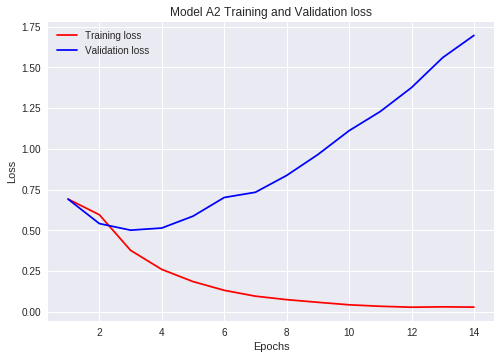

In [26]:
history_dict_a2 = history_a2.history
loss = history_dict_a2['loss']
val_loss = history_dict_a2['val_loss']
acc = history_dict_a2['acc']
val_acc = history_dict_a2['val_acc']

epochs = range(1,15)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Model A2 Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

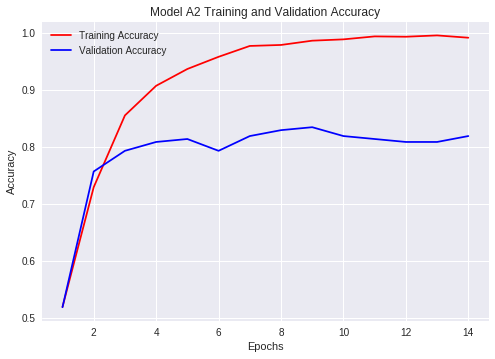

In [27]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Model A2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Both Model A and Model A2 got up to 83.42%. They both beat the Logistic Regression model.

Now, lets try a different type of architecture: RNN's.

Well try using both LSTM and bidirectional LSTMs. For LSTM's, I'll try one with one LSTM layer (Model B) and another with stacked LSTM's layers (Model C). Model D will employ bidirectional LSTM's.

In [28]:
K.clear_session()
# model b: LSTM
model_b = Sequential()
model_b.add(layers.Embedding(vocab_size, 50))
model_b.add(layers.LSTM(64))
model_b.add(layers.Dense(10, activation='relu'))
model_b.add(layers.Dense(1, activation='sigmoid'))

# compile
model_b.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          212200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 242,301
Trainable params: 242,301
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_b = model_b.fit(X_train_nn, y_train,
                   epochs=10,
                   batch_size=10,
                   validation_split=0.1)

Train on 1730 samples, validate on 193 samples
Epoch 1/10
1730/1730 [==============================] - 45s 26ms/step - loss: 0.6619 - acc: 0.5913 - val_loss: 0.5830 - val_acc: 0.7047
Epoch 2/10
1730/1730 [==============================] - 44s 26ms/step - loss: 0.4475 - acc: 0.8162 - val_loss: 0.4867 - val_acc: 0.7979
Epoch 3/10
1730/1730 [==============================] - 45s 26ms/step - loss: 0.2955 - acc: 0.8884 - val_loss: 0.4583 - val_acc: 0.7772
Epoch 4/10
1730/1730 [==============================] - 44s 25ms/step - loss: 0.2591 - acc: 0.9185 - val_loss: 0.4872 - val_acc: 0.7927
Epoch 5/10
1730/1730 [==============================] - 44s 25ms/step - loss: 0.1794 - acc: 0.9416 - val_loss: 0.5462 - val_acc: 0.8031
Epoch 6/10
1730/1730 [==============================] - 44s 26ms/step - loss: 0.1394 - acc: 0.9566 - val_loss: 0.5315 - val_acc: 0.8135
Epoch 7/10
1730/1730 [==============================] - 43s 25ms/step - loss: 0.1255 - acc: 0.9595 - val_loss: 0.5763 - val_acc: 0.8187
E

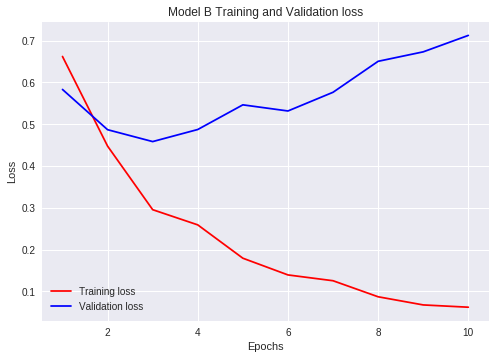

In [30]:
history_dict_b = history_b.history
loss = history_dict_b['loss']
val_loss = history_dict_b['val_loss']
acc = history_dict_b['acc']
val_acc = history_dict_b['val_acc']

epochs = range(1,11)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Model B Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

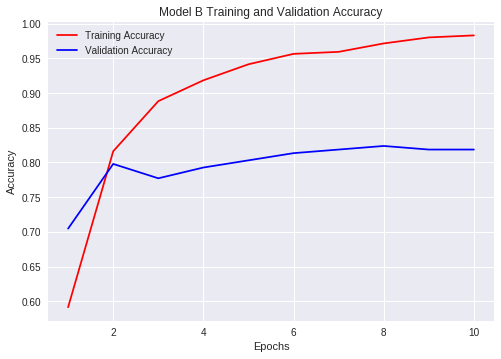

In [31]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Model B Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Our model achieved an accuracy of about 82.38% but it began overfitting around 2 epochs. 

Now for Model C a stacked LSTM model and then Model D a bidirectional LSTM.

This time I will implement early stopping to help fight overfitting - also it helps speed up the process.

In [32]:
K.clear_session()
# model c: stacked LSTM
model_c = Sequential()
model_c.add(layers.Embedding(vocab_size, 50))
model_c.add(layers.LSTM(32, return_sequences=True))
model_c.add(layers.LSTM(16))
model_c.add(layers.Dense(10, activation='relu'))
model_c.add(layers.Dense(1, activation='sigmoid'))

# compile
model_c.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# early stopping to help with overfitting
early_stop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          212200    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          10624     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 226,141
Trainable params: 226,141
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_c = model_c.fit(X_train_nn, y_train,
                   epochs=10,
                   batch_size=10,
                   validation_split=0.1,
                   callbacks=[early_stop])

Train on 1730 samples, validate on 193 samples
Epoch 1/10
1730/1730 [==============================] - 85s 49ms/step - loss: 0.6770 - acc: 0.5699 - val_loss: 0.6427 - val_acc: 0.6321
Epoch 2/10
1730/1730 [==============================] - 85s 49ms/step - loss: 0.4875 - acc: 0.7850 - val_loss: 0.4889 - val_acc: 0.7358
Epoch 3/10
1730/1730 [==============================] - 84s 49ms/step - loss: 0.3093 - acc: 0.8803 - val_loss: 0.4540 - val_acc: 0.7824
Epoch 4/10
1730/1730 [==============================] - 85s 49ms/step - loss: 0.2171 - acc: 0.9254 - val_loss: 0.4799 - val_acc: 0.7927
Epoch 5/10
1730/1730 [==============================] - 85s 49ms/step - loss: 0.1680 - acc: 0.9462 - val_loss: 0.5210 - val_acc: 0.7979
Epoch 6/10
1730/1730 [==============================] - 84s 48ms/step - loss: 0.1392 - acc: 0.9590 - val_loss: 0.5325 - val_acc: 0.7979
Epoch 7/10
1730/1730 [==============================] - 84s 48ms/step - loss: 0.1158 - acc: 0.9636 - val_loss: 0.5346 - val_acc: 0.8031
E

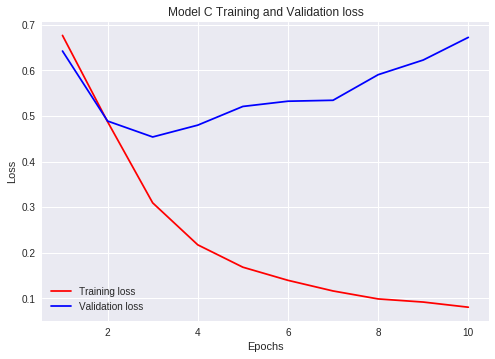

In [34]:
history_dict_c = history_c.history
loss = history_dict_c['loss']
val_loss = history_dict_c['val_loss']
acc = history_dict_c['acc']
val_acc = history_dict_c['val_acc']

epochs = range(1,11)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Model C Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

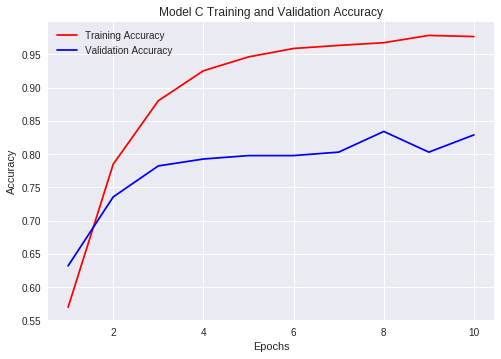

In [35]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Model C Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The stacked LSTM model got up to 83.43% accuracy. Now lets try a Bidirectional LSTM.


In [36]:
# bidirectional LSTM
K.clear_session()

model_d = Sequential()
model_d.add(layers.Embedding(vocab_size, 50))
model_d.add(layers.Bidirectional(layers.LSTM(64)))
model_d.add(layers.Dense(10, activation='relu'))
model_d.add(layers.Dense(1, activation='sigmoid'))

# compile
model_d.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          212200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 272,381
Trainable params: 272,381
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_d = model_d.fit(X_train_nn, y_train,
                   epochs=10,
                   batch_size=10,
                   validation_split=0.1,
                   callbacks=[early_stop])

Train on 1730 samples, validate on 193 samples
Epoch 1/10
1730/1730 [==============================] - 84s 49ms/step - loss: 0.6916 - acc: 0.5867 - val_loss: 0.5664 - val_acc: 0.7098
Epoch 2/10
1730/1730 [==============================] - 81s 47ms/step - loss: 0.4870 - acc: 0.8081 - val_loss: 0.4638 - val_acc: 0.7979
Epoch 3/10
1730/1730 [==============================] - 82s 48ms/step - loss: 0.2703 - acc: 0.9017 - val_loss: 0.4607 - val_acc: 0.8031
Epoch 4/10
1730/1730 [==============================] - 81s 47ms/step - loss: 0.2391 - acc: 0.9335 - val_loss: 0.5362 - val_acc: 0.8238
Epoch 5/10
1730/1730 [==============================] - 82s 47ms/step - loss: 0.1621 - acc: 0.9439 - val_loss: 0.4907 - val_acc: 0.7927
Epoch 6/10
1730/1730 [==============================] - 81s 47ms/step - loss: 0.1394 - acc: 0.9578 - val_loss: 0.5392 - val_acc: 0.8031
Epoch 7/10
1730/1730 [==============================] - 82s 47ms/step - loss: 0.1256 - acc: 0.9607 - val_loss: 0.6081 - val_acc: 0.8238
E

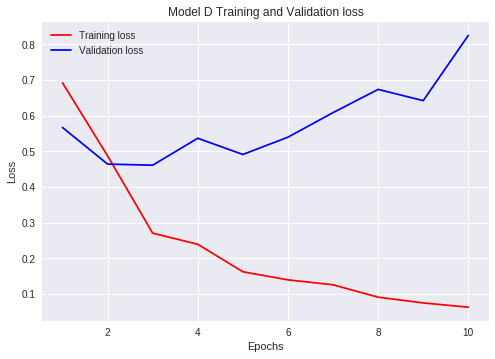

In [38]:
history_dict_d = history_d.history
loss = history_dict_d['loss']
val_loss = history_dict_d['val_loss']
acc = history_dict_d['acc']
val_acc = history_dict_d['val_acc']

epochs = range(1,11)
plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs, val_loss, c='b', label='Validation loss')
plt.title('Model D Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

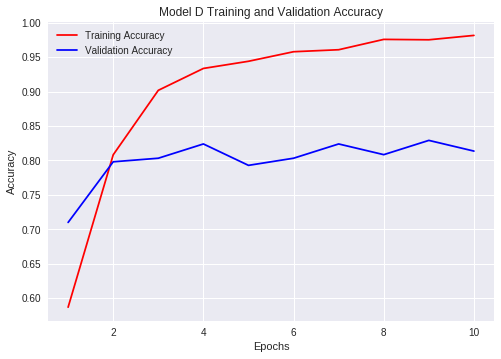

In [39]:
plt.plot(epochs, acc, c='r', label='Training Accuracy')
plt.plot(epochs, val_acc, c='b', label='Validation Accuracy')
plt.title('Model D Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Summary

Out of all of our deep models, Models A and A2 (CNN architecture) had the highest validation accuracies

This tells us that adding complexity isnt necessarily making better predictions. To finish up this project well not try optimizing our best models. As of now, the CNN models had the best validation accuracy, so we will try to optimize both Model A and A2 using randomized grid search. It takes a while, so wait a bit to see the results. 



### Hyperparameter optimization

In order to use grid search we have to wrap our model in a sklearn wrapper using KerasClassifier. We also need to a build a function that builds the model for us. That function will then be passed into the KerasClassifier function, which is then input to the grid search function.

In [0]:
# build function for model A
def build_model_a(num_filters, 
                kernel_size, 
                vocab_size, 
                embedding_dim, 
                lr):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim))
  model.add(layers.Conv1D(num_filters, embedding_dim, activation='relu'))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=RMSprop(lr=lr),
             loss='binary_crossentropy',
             metrics=['accuracy'])
  return model

In [0]:
# set up parameter grid for A
param_grid_a = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[32,48,50],
                  lr=[0.0001, 0.001, 0.01, 0.10])

In [55]:
# grid search for model A
cnn = KerasClassifier(build_fn=build_model_a,
                            epochs=10, batch_size=10,
                            verbose=False)
grid2 = RandomizedSearchCV(estimator=cnn,
                           param_distributions=param_grid_a,
                           cv=kfold,
                           verbose=1,
                           scoring='accuracy',
                          n_iter=10,
                          n_jobs=-1)
grid_result2 = grid2.fit(X_train_nn, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.7min finished


In [57]:
grid_result2.best_params_

{'embedding_dim': 32,
 'kernel_size': 3,
 'lr': 0.001,
 'num_filters': 32,
 'vocab_size': 5000}

In [58]:
grid_result2.best_score_

0.8049921996879875

In [0]:
# build function for model A2
def build_model_a2(num_filters, 
                kernel_size, 
                vocab_size, 
                embedding_dim, 
                lr):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim))
  model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
  model.add(layers.MaxPooling1D())
  model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=RMSprop(lr=lr),
             loss='binary_crossentropy',
             metrics=['accuracy'])
  return model


In [0]:
# set up parameter grid for A2
param_grid_a2 = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[32,48,50],
                  lr=[0.0001, 0.001, 0.01, 0.10])

In [62]:
# grid search for model A
cnn2 = KerasClassifier(build_fn=build_model_a2,
                            epochs=10, batch_size=10,
                            verbose=False)
grid3 = RandomizedSearchCV(estimator=cnn2,
                           param_distributions=param_grid_a2,
                           cv=kfold,
                           verbose=1,
                           scoring='accuracy',
                          n_iter=10,
                          n_jobs=-1)
grid_result3 = grid3.fit(X_train_nn, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.4min finished


In [63]:
grid_result3.best_params_

{'embedding_dim': 50,
 'kernel_size': 3,
 'lr': 0.001,
 'num_filters': 32,
 'vocab_size': 5000}

In [64]:
grid_result3.best_score_

0.7997919916796672

# Best Models 

- Logistic Regression with a best validation accuracy of 83.03%
- CNN with 1 convolutional layer with a best validation accuracy of 83.42%
- CNN with 2 convolutional layers with a best validation accuracy of 83.42%


The deep models got the highest the accuracies, but not by much and also required a lot of computational power, 

In [65]:
best_lr

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [68]:
grid_result2.best_params_


{'embedding_dim': 32,
 'kernel_size': 3,
 'lr': 0.001,
 'num_filters': 32,
 'vocab_size': 5000}

In [70]:
grid_result3.best_params_

{'embedding_dim': 50,
 'kernel_size': 3,
 'lr': 0.001,
 'num_filters': 32,
 'vocab_size': 5000}

# Final Evaluation of Both Shallow and Deep Models

Lets now construct our final models and evaluate them on the test set. From our deeper models well go with Model A - using the hyperparameters found during the randomized grid search. Well then do the same for our best logistic regression model. 

In [78]:
# build final CNN and evaluate
K.clear_session()

final_model = Sequential()
final_model.add(layers.Embedding(5000, 32, input_length=maxlen))
final_model.add(layers.Conv1D(32, 3, activation='relu'))
final_model.add(layers.GlobalMaxPooling1D())
final_model.add(layers.Dense(10, activation='relu'))
final_model.add(layers.Dense(1, activation='sigmoid'))

# compile
final_model.compile(optimizer=RMSprop(lr=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 32)            3104      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 163,445
Trainable params: 163,445
Non-trainable params: 0
_________________________________________________________________


In [80]:
final_model.fit(X_train_nn, y_train, epochs=15, batch_size=15)

Epoch 1/15
1923/1923 [==============================] - 1s 494us/step - loss: 0.0499 - acc: 0.9844
Epoch 2/15
1923/1923 [==============================] - 1s 437us/step - loss: 0.0396 - acc: 0.9860
Epoch 3/15
1923/1923 [==============================] - 1s 462us/step - loss: 0.0285 - acc: 0.9912
Epoch 4/15
1923/1923 [==============================] - 1s 523us/step - loss: 0.0211 - acc: 0.9953
Epoch 5/15
1923/1923 [==============================] - 1s 518us/step - loss: 0.0153 - acc: 0.9984
Epoch 6/15
1923/1923 [==============================] - 1s 519us/step - loss: 0.0115 - acc: 0.9979
Epoch 7/15
1923/1923 [==============================] - 1s 511us/step - loss: 0.0086 - acc: 0.9990
Epoch 8/15
1923/1923 [==============================] - 1s 514us/step - loss: 0.0072 - acc: 0.9990
Epoch 9/15
1923/1923 [==============================] - 1s 521us/step - loss: 0.0066 - acc: 0.9990
Epoch 10/15
1923/1923 [==============================] - 1s 518us/step - loss: 0.0045 - acc: 0.9995
Epoch 11/

In [81]:
test_loss, test_acc = final_model.evaluate(X_test_nn, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

825/825 [==============================] - 0s 120us/step
Test loss: 1.2017212315761683
Test accuracy: 0.8012121204173926


In [82]:
# best logistic regression final evaluation
best_lr.score(X_test_vec, y_test)

0.8303030303030303

# Final Summary

Our best model ended up being a simple Logistic Regression with some regularization. While our score isn't that great, its a decent starting point. Something also to consider is the amount of data we used. With more data, the neural networks could have performed better. And we could also continue to experiment, trying different deep architectures, and maybe some other shallow models - e.g. XGBoost - but for the sake of this notebook we will not proceed any further.

If you have questions, please feel free to contact me at:
aponted511@gmail.com

Thank you!